In [167]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [168]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\Train\\benign',224))
malign_train = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\Train\\malignant',224))
benign_test = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\validation\\benign',224))
malign_test = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\validation\\malignant',224))

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 167.11it/s]


In [169]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

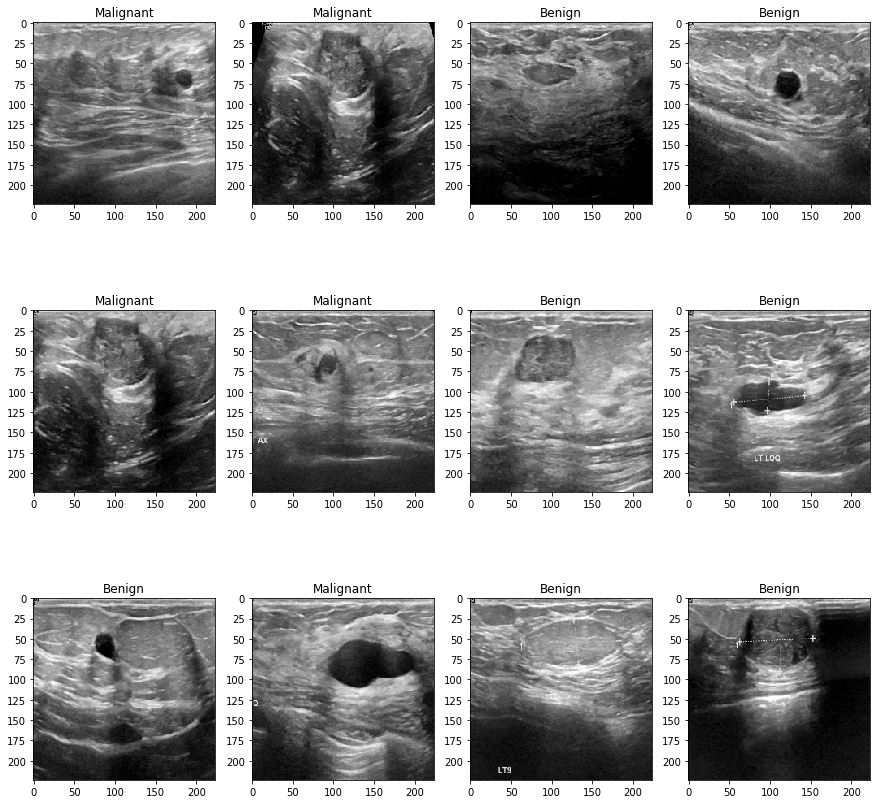

In [170]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [171]:
y_train.shape

(455, 2)

In [172]:
y_val.shape

(114, 2)

In [173]:
x_val.shape

(114, 224, 224, 3)

In [174]:
x_train.shape

(455, 224, 224, 3)

In [175]:
y_train[:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [180]:
model = Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(layers.Dense(64, activation='softmax'))
model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(2, activation='softmax'))
    
model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)




In [177]:
x_train = x_train/255.0
x_val = x_val/255.0

In [178]:
x_train

array([[[[0.59607843, 0.59607843, 0.59607843],
         [0.59215686, 0.59215686, 0.59215686],
         [0.59215686, 0.59215686, 0.59215686],
         ...,
         [0.45882353, 0.45882353, 0.45882353],
         [0.09803922, 0.09803922, 0.09803922],
         [0.01176471, 0.01176471, 0.01176471]],

        [[0.64705882, 0.64705882, 0.64705882],
         [0.62745098, 0.62745098, 0.62745098],
         [0.61960784, 0.61960784, 0.61960784],
         ...,
         [0.48235294, 0.48235294, 0.48235294],
         [0.46666667, 0.46666667, 0.46666667],
         [0.01568627, 0.01568627, 0.01568627]],

        [[0.65490196, 0.65490196, 0.65490196],
         [0.63529412, 0.63529412, 0.63529412],
         [0.61176471, 0.61176471, 0.61176471],
         ...,
         [0.50196078, 0.50196078, 0.50196078],
         [0.50196078, 0.50196078, 0.50196078],
         [0.04313725, 0.04313725, 0.04313725]],

        ...,

        [[0.31764706, 0.31764706, 0.31764706],
         [0.32941176, 0.32941176, 0.32941176]

In [181]:
model_history = model.fit(x_train, y_train,
          batch_size=10,
          epochs=10,
          verbose=1,
          validation_data=(x_val,y_val))

Epoch 1/10
46/46 [==============================] - 17s 330ms/step - loss: 0.6855 - accuracy: 0.6649 - val_loss: 0.6791 - val_accuracy: 0.6404
Epoch 2/10
46/46 [==============================] - 15s 319ms/step - loss: 0.6695 - accuracy: 0.6934 - val_loss: 0.6711 - val_accuracy: 0.6404
Epoch 3/10
46/46 [==============================] - 15s 325ms/step - loss: 0.6572 - accuracy: 0.6979 - val_loss: 0.6655 - val_accuracy: 0.6404
Epoch 4/10
46/46 [==============================] - 16s 352ms/step - loss: 0.6492 - accuracy: 0.6943 - val_loss: 0.6611 - val_accuracy: 0.6404
Epoch 5/10
46/46 [==============================] - 15s 331ms/step - loss: 0.6374 - accuracy: 0.7077 - val_loss: 0.6576 - val_accuracy: 0.6404
Epoch 6/10
46/46 [==============================] - 15s 326ms/step - loss: 0.6327 - accuracy: 0.7002 - val_loss: 0.6545 - val_accuracy: 0.6404
Epoch 7/10
46/46 [==============================] - 15s 317ms/step - loss: 0.6367 - accuracy: 0.6752 - val_loss: 0.6520 - val_accuracy: 0.6404

In [182]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
global_average_pooling2d_11  (None, 64)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 64)              

In [183]:
X_test

array([[[[ 22,  22,  22],
         [138, 138, 138],
         [ 43,  43,  43],
         ...,
         [157, 157, 157],
         [161, 161, 161],
         [159, 159, 159]],

        [[  2,   2,   2],
         [101, 101, 101],
         [ 68,  68,  68],
         ...,
         [159, 159, 159],
         [154, 154, 154],
         [165, 165, 165]],

        [[ 99,  99,  99],
         [155, 155, 155],
         [ 49,  49,  49],
         ...,
         [170, 170, 170],
         [153, 153, 153],
         [155, 155, 155]],

        ...,

        [[ 23,  23,  23],
         [ 24,  24,  24],
         [ 22,  22,  22],
         ...,
         [ 38,  38,  38],
         [ 32,  32,  32],
         [ 21,  21,  21]],

        [[ 25,  25,  25],
         [ 19,  19,  19],
         [ 21,  21,  21],
         ...,
         [ 26,  26,  26],
         [ 27,  27,  27],
         [ 24,  24,  24]],

        [[ 30,  30,  30],
         [ 27,  27,  27],
         [ 24,  24,  24],
         ...,
         [ 22,  22,  22],
        

In [192]:
Y_pred = model.predict(X_test, steps=1,verbose =1)

1/1 [==============================] - 1s 569ms/step


Confusion matrix, without normalization
[[54  0]
 [24  0]]


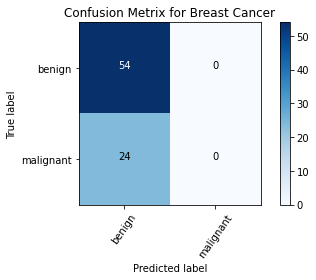

In [194]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1),zero_division=_division=1)

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

<AxesSubplot:>

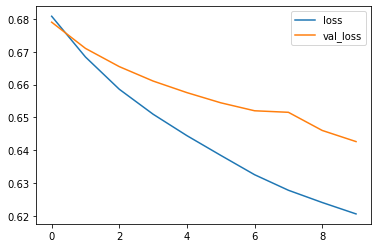

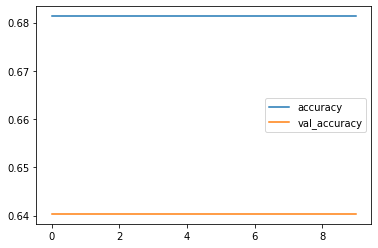

In [187]:
history_df = pd.DataFrame(model_history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(model_history.history)
history_df[['accuracy', 'val_accuracy']].plot()